# Equity in Mortality Prediction

How our tools perform across ethnical groups and diverse demographics?


## Load libraries and connect to the database

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
plt.style.use('ggplot')

# model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
# authenticate
auth.authenticate_user()

In [0]:
# Set up environment variables
project_id='hack-aotearoa'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return fpr, tpr, thr

def plot_roc_curve_multiple(data, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for k,v in data.items():
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = v[0], y_score = v[1], drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=4, alpha=0.3,
                 label= f'ROC for {k} (AUC = {roc_auc:.4f})')
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
   

## Load the patient cohort

In [0]:
%%bigquery mimiciii

SELECT saps.*, ad.RELIGION, ad.ETHNICITY, ad.MARITAL_STATUS, ad.INSURANCE, p.gender,
CASE WHEN ad.deathtime BETWEEN i.intime AND i.outtime
THEN 1
ELSE 0 END
AS mort_icu
FROM `physionet-data.mimiciii_derived.sapsii` saps
JOIN `physionet-data.mimiciii_clinical.admissions` ad on saps.hadm_id = ad.HADM_ID
JOIN `physionet-data.mimiciii_clinical.icustays` i on saps.icustay_id = i.ICUSTAY_ID
JOIN `physionet-data.mimiciii_clinical.patients` p on saps.SUBJECT_ID = p.SUBJECT_ID
ORDER BY saps.subject_id

In [6]:
### Function for converting the ethnicity data into coarser categories
def ethnicCoding(dfIN, inColName, outColName):
  
  # fill in missing data to 'other'
  dfIN[inColName][dfIN[inColName].isnull()] = "other"
  # conver to lower
  dfIN[inColName] = dfIN[inColName].str.lower()

  #1	WHITE
  #12	WHITE - EASTERN EUROPEAN
  #14	WHITE - RUSSIAN
  #24	WHITE - OTHER EUROPEAN
  whiteMask = pd.Series(dfIN[inColName]).str.contains('white').tolist()
  dfIN.loc[whiteMask, outColName] = 'white'

  #2	BLACK/AFRICAN AMERICAN
  #13	BLACK/CAPE VERDEAN
  #15	BLACK/HAITIAN
  #16	CARIBBEAN ISLAND
  #18	BLACK/AFRICAN
  blackMask = pd.Series(dfIN[inColName]).str.contains('black|caribbean').tolist()
  dfIN.loc[blackMask, outColName] = 'black'

  #3	HISPANIC/LATINO - PUERTO RICAN
  #6	HISPANIC OR LATINO
  #21	HISPANIC/LATINO - DOMINICAN
  #22	HISPANIC/LATINO - CUBAN
  #23	HISPANIC/LATINO - GUATEMALAN
  #26	PORTUGUESE
  #28	SOUTH AMERICAN
  #30	HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)
  #33	HISPANIC/LATINO - SALVADORAN
  #35	WHITE - BRAZILIAN
  #36	HISPANIC/LATINO - COLOMBIAN
  #38	HISPANIC/LATINO - MEXICAN
  #41	HISPANIC/LATINO - HONDURAN
  hispMask = pd.Series(dfIN[inColName]).str.contains('hispanic|portuguese|south american|brazilian').tolist()
  dfIN.loc[hispMask, outColName] = 'hispanic'

  #4	OTHER
  #7	UNKNOWN/NOT SPECIFIED
  #8	PATIENT DECLINED TO ANSWER
  #11	MULTI RACE ETHNICITY
  #17	UNABLE TO OBTAIN
  unknownMask = pd.Series(dfIN[inColName]).str.contains('other|unknown|declined|multi|unable').tolist()
  dfIN.loc[unknownMask, outColName] = 'other'  

  #5	ASIAN
  #9	ASIAN - CHINESE
  #19	ASIAN - OTHER
  #20	ASIAN - FILIPINO
  #25	ASIAN - KOREAN
  #27	ASIAN - CAMBODIAN
  #29	ASIAN - ASIAN INDIAN
  #31	ASIAN - VIETNAMESE
  #37	ASIAN - THAI
  #40	ASIAN - JAPANESE
  asianMask = pd.Series(dfIN[inColName]).str.contains('asian').tolist()
  dfIN.loc[asianMask, outColName] = 'asian'  
  
  #10 AMERICAN INDIAN/ALASKA NATIVE
  #39	AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE
  americanindianMask = pd.Series(dfIN[inColName]).str.contains('american indian').tolist()
  dfIN.loc[americanindianMask, outColName] = 'americanindian'  
  
  #32	MIDDLE EASTERN
  middleeasternMask = pd.Series(dfIN[inColName]).str.contains('middle').tolist()
  dfIN.loc[middleeasternMask, outColName] = 'middle'  
  
  #34	NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER
  pacificMask = pd.Series(dfIN[inColName]).str.contains('pacific').tolist()
  dfIN.loc[pacificMask, outColName] = 'pacific'  
  
  return(dfIN)
  
### Function for converting the religion data into coarser categories
def religionCoding(dfIN, inColName, outColName):
  
  # fill in missing data to 'other'
  dfIN[inColName][dfIN[inColName].isnull()] = "other"
  # conver to lower
  dfIN[inColName] = dfIN[inColName].str.lower()

#1	EPISCOPALIAN
#5	CATHOLIC
#7	PROTESTANT QUAKER
#8	GREEK ORTHODOX
#9	JEHOVAH'S WITNESS
#10	UNITARIAN-UNIVERSALIST
#12	7TH DAY ADVENTIST
#13	BAPTIST
#16	METHODIST
#18	CHRISTIAN SCIENTIST
#19	ROMANIAN EAST. ORTH
#21	LUTHERAN
  christianMask = pd.Series(dfIN[inColName]).str.contains('episc|catho|prote|greek|jehov|unit|adven|bapt|meth|scien|roman|luth').tolist()
  dfIN.loc[christianMask, outColName] = 'christian'
  
#2	OTHER
#4	NOT SPECIFIED
#6	UNOBTAINABLE
#11	null
  otherMask = pd.Series(dfIN[inColName]).str.contains('other|specif|unob|null').tolist()
  dfIN.loc[otherMask, outColName] = 'other' 

#3	JEWISH
#17	HEBREW
  jewMask = pd.Series(dfIN[inColName]).str.contains('jew|hebr').tolist()
  dfIN.loc[jewMask, outColName] = 'jewish' 

#14	BUDDHIST
  budMask = pd.Series(dfIN[inColName]).str.contains('buddhist').tolist()
  dfIN.loc[budMask, outColName] = 'buddhist' 

#15	MUSLIM
  muslimMask = pd.Series(dfIN[inColName]).str.contains('muslim').tolist()
  dfIN.loc[muslimMask, outColName] = 'muslim' 

#20	HINDU
  hinduMask = pd.Series(dfIN[inColName]).str.contains('hindu').tolist()
  dfIN.loc[hinduMask, outColName] = 'hindu' 
  
  return(dfIN)
  
  
def doConversions(dfIN):
  dfIN = ethnicCoding(dfIN, 'ETHNICITY', "EthCat")
  dfIN = religionCoding(dfIN, "RELIGION", "RelCat")
  return(dfIN)

mimiciii = doConversions(mimiciii)
mimiciii.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,subject_id,hadm_id,icustay_id,SAPSII,SAPSII_PROB,age_score,hr_score,sysbp_score,temp_score,PaO2FiO2_score,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender,mort_icu,EthCat,RelCat
0,2,163353,243653,22,0.046739,0,4.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,0,6,not specified,asian,None,Private,M,0,asian,other
1,3,145834,211552,79,0.918976,16,7.0,13.0,0.0,6.0,11.0,6.0,3.0,3.0,1.0,5.0,0.0,0.0,0,8,catholic,white,MARRIED,Medicare,M,0,white,christian
2,4,185777,294638,35,0.166523,7,0.0,5.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,protestant quaker,white,SINGLE,Private,F,0,white,christian
3,5,178980,214757,6,0.004584,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,6,buddhist,asian,None,Private,M,0,asian,buddhist
4,6,107064,228232,24,0.058153,12,0.0,0.0,0.0,NaN,0.0,6.0,0.0,3.0,0.0,3.0,0.0,0.0,0,0,not specified,white,MARRIED,Medicare,F,0,white,other


In [7]:
mimiciii['predicted_mort_icu'] = mimiciii['SAPSII_PROB'] > 0.5
mimiciii['predicted_mort_icu'] = mimiciii['predicted_mort_icu'].astype(int)
mimiciii.head()

,subject_id,hadm_id,icustay_id,SAPSII,SAPSII_PROB,age_score,hr_score,sysbp_score,temp_score,PaO2FiO2_score,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender,mort_icu,EthCat,RelCat,predicted_mort_icu
0,2,163353,243653,22,0.046739,0,4.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,0,6,not specified,asian,None,Private,M,0,asian,other,0
1,3,145834,211552,79,0.918976,16,7.0,13.0,0.0,6.0,11.0,6.0,3.0,3.0,1.0,5.0,0.0,0.0,0,8,catholic,white,MARRIED,Medicare,M,0,white,christian,1
2,4,185777,294638,35,0.166523,7,0.0,5.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,protestant quaker,white,SINGLE,Private,F,0,white,christian,0
3,5,178980,214757,6,0.004584,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,6,buddhist,asian,None,Private,M,0,asian,buddhist,0
4,6,107064,228232,24,0.058153,12,0.0,0.0,0.0,NaN,0.0,6.0,0.0,3.0,0.0,3.0,0.0,0.0,0,0,not specified,white,MARRIED,Medicare,F,0,white,other,0


## Overall Performance

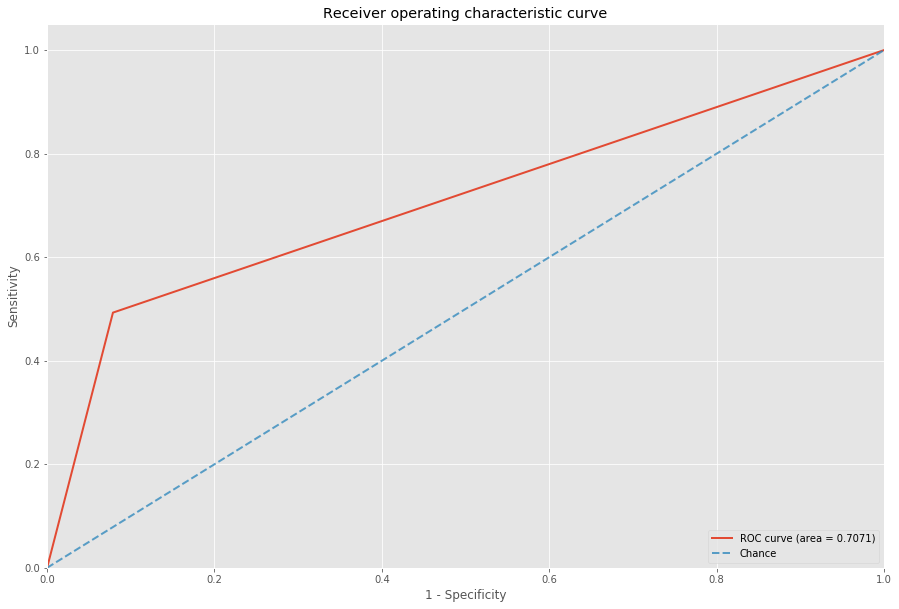

In [22]:
observed_mortality = mimiciii[['mort_icu']].values
predicted_mortality = mimiciii[['predicted_mort_icu']].values
plot_roc_curve(observed_mortality, predicted_mortality, filename='ROC_overall')

## Performance by Gender

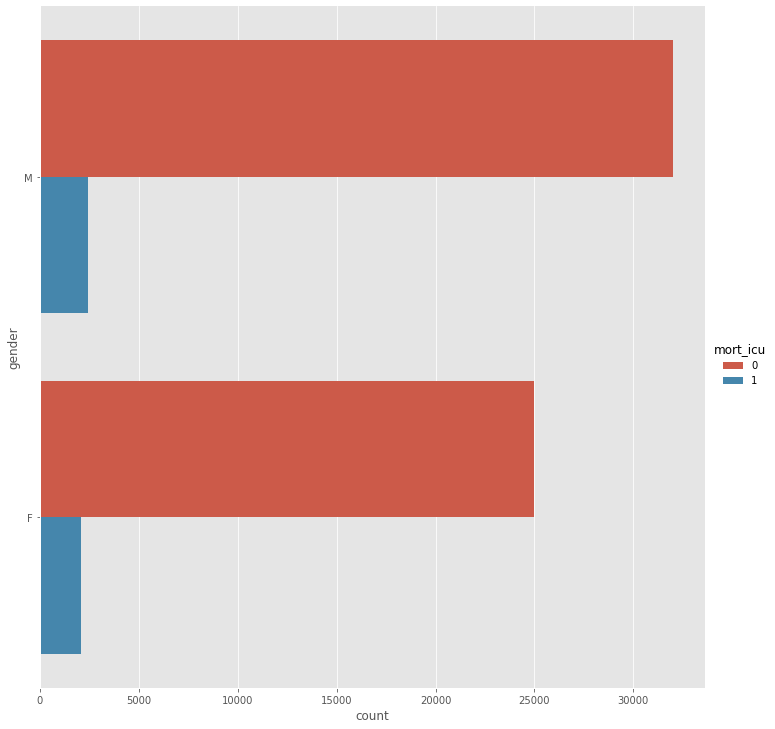

In [9]:
sbs.catplot(y='gender', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

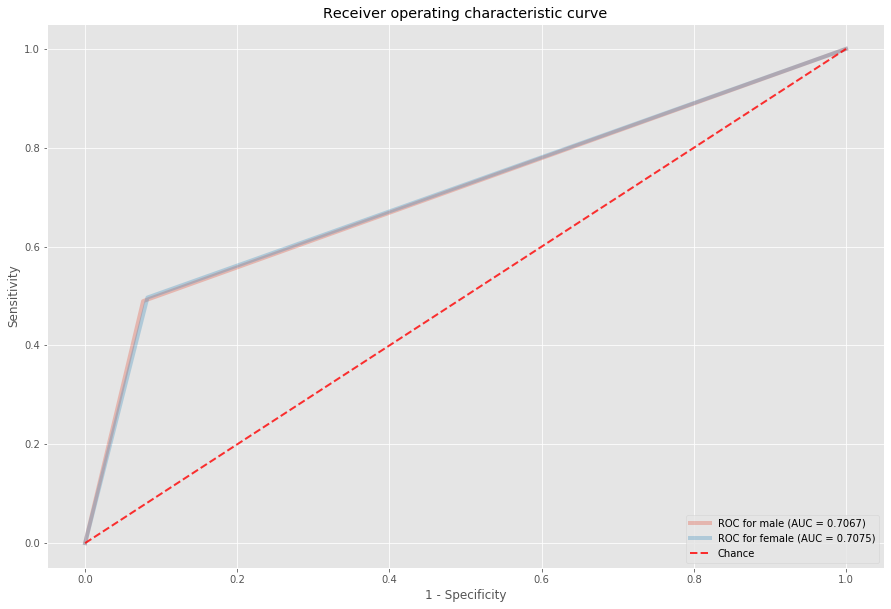

In [23]:
data = dict()
data['male'] = [mimiciii[mimiciii.gender == 'M'][['mort_icu']].values,
                mimiciii[mimiciii.gender == 'M'][['predicted_mort_icu']].values]
data['female'] = [mimiciii[mimiciii.gender == 'F'][['mort_icu']].values,
                  mimiciii[mimiciii.gender == 'F'][['predicted_mort_icu']].values]
plot_roc_curve_multiple(data, filename='ROC_gender')
#print(data.items())

## Performance by Ethnicity

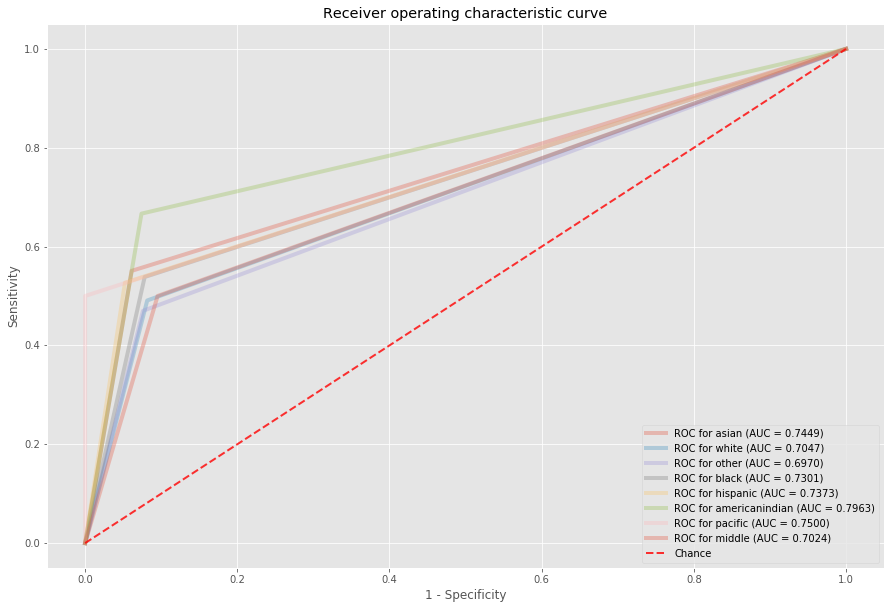

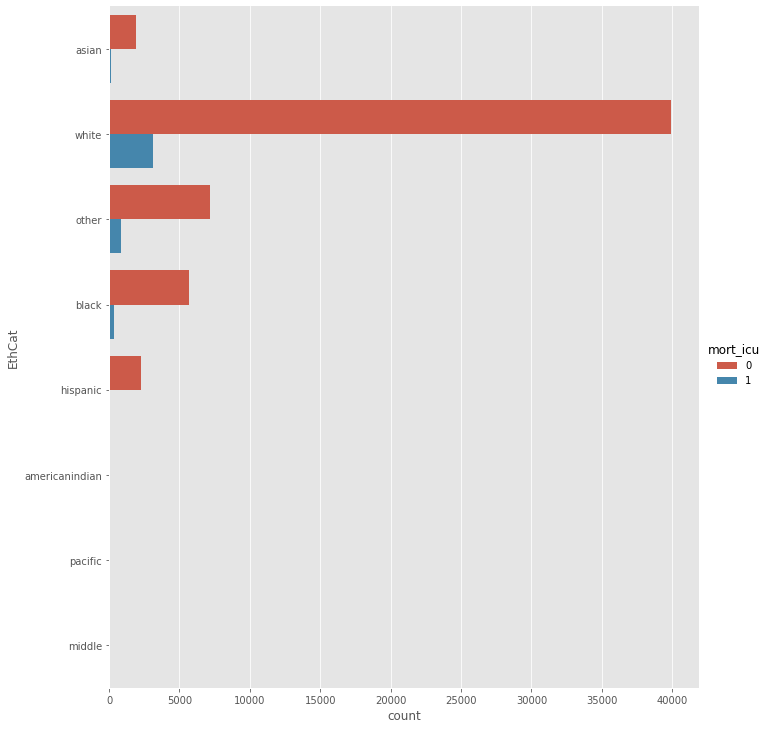

In [24]:
data = dict()
for e in mimiciii.EthCat.unique():
  data[e] = [mimiciii[mimiciii.EthCat == e][['mort_icu']].values,
                mimiciii[mimiciii.EthCat == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_ethnicity')
sbs.catplot(y='EthCat', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

## Performance by Marital Status

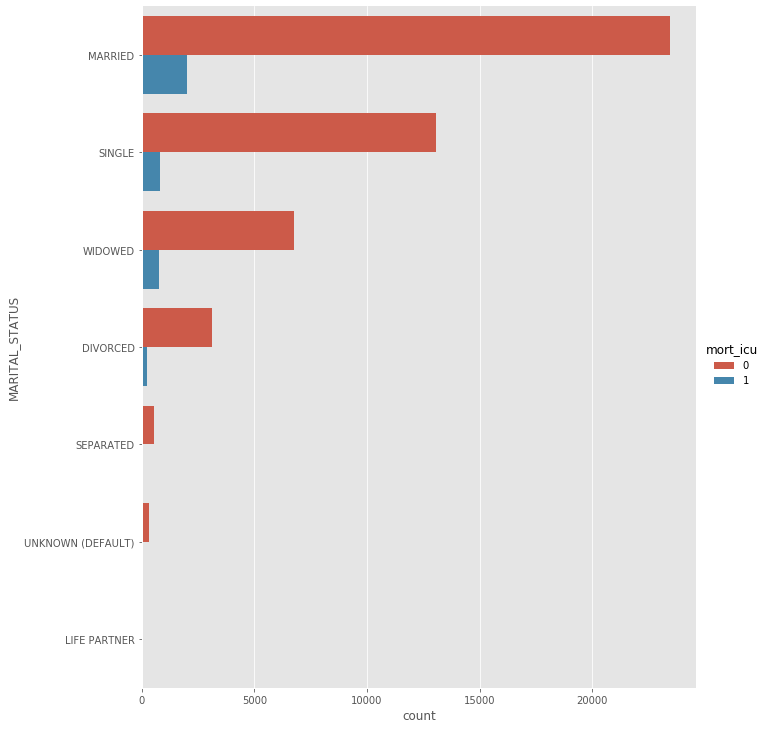

In [12]:
sbs.catplot(y='MARITAL_STATUS', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

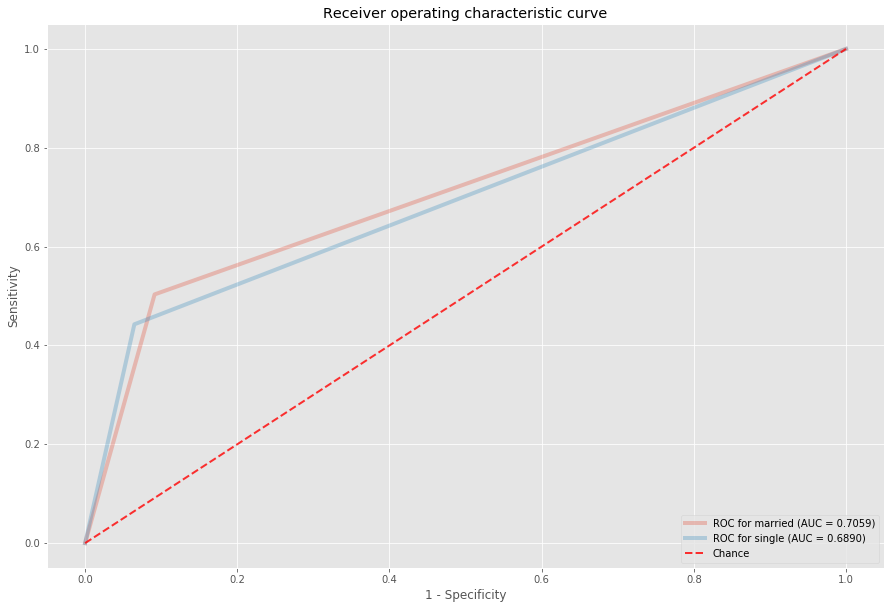

In [25]:
data = dict()
data['married'] = [mimiciii[mimiciii.MARITAL_STATUS == 'MARRIED'][['mort_icu']].values,
                   mimiciii[mimiciii.MARITAL_STATUS == 'MARRIED'][['predicted_mort_icu']].values]
data['single'] = [mimiciii[mimiciii.MARITAL_STATUS == 'SINGLE'][['mort_icu']].values,
                  mimiciii[mimiciii.MARITAL_STATUS == 'SINGLE'][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_marital')

## Performance by Insurance Status

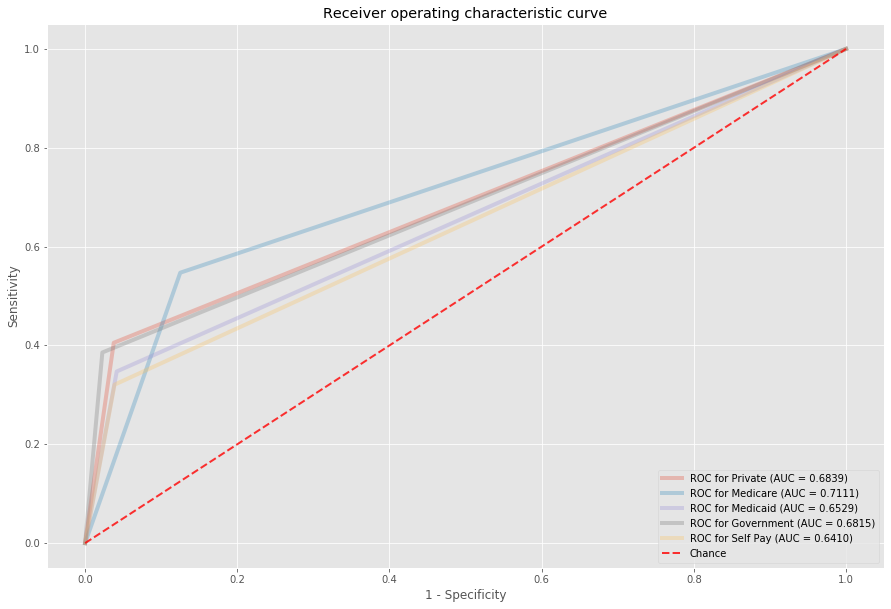

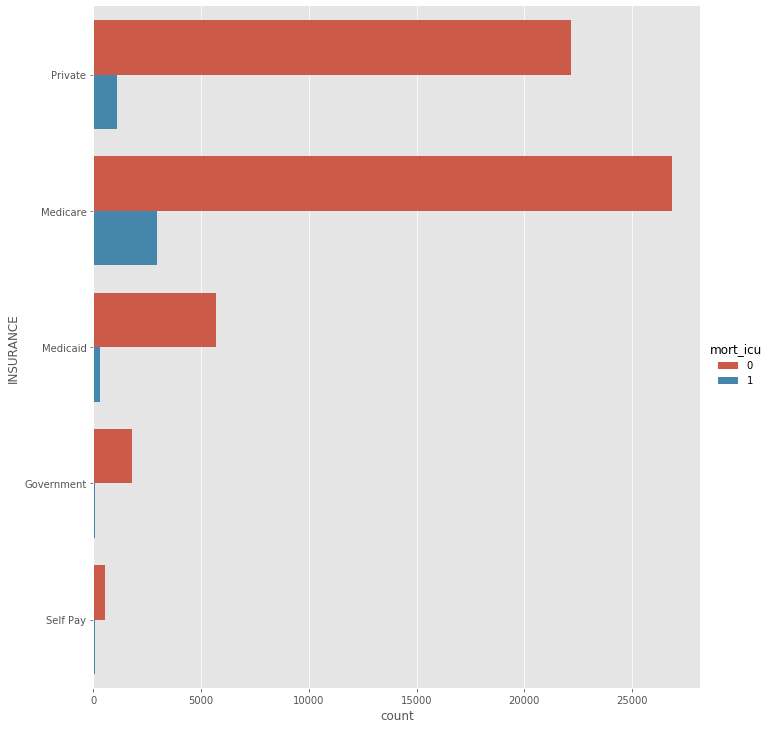

In [26]:
data = dict()
for e in mimiciii.INSURANCE.unique():
  data[e] = [mimiciii[mimiciii.INSURANCE == e][['mort_icu']].values,
                mimiciii[mimiciii.INSURANCE == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_insurance')
sbs.catplot(y='INSURANCE', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

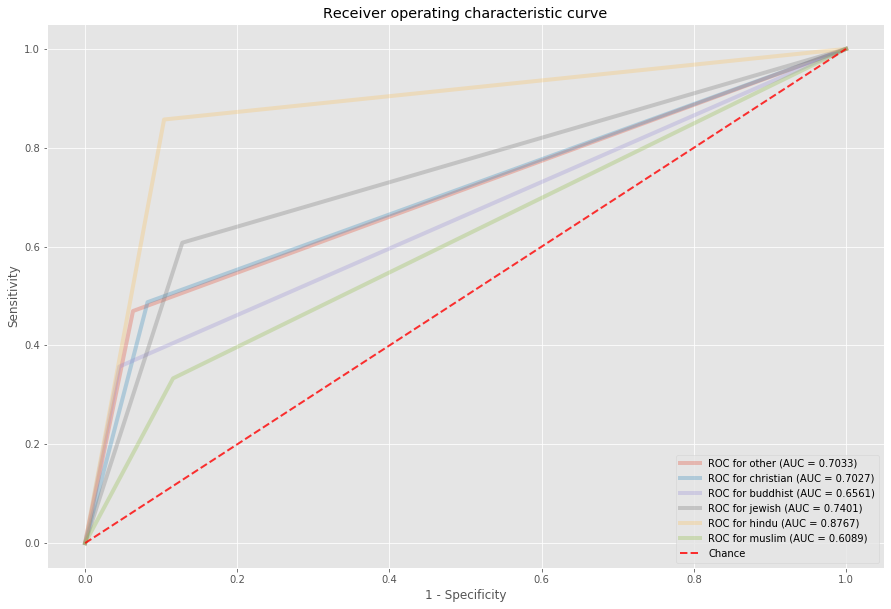

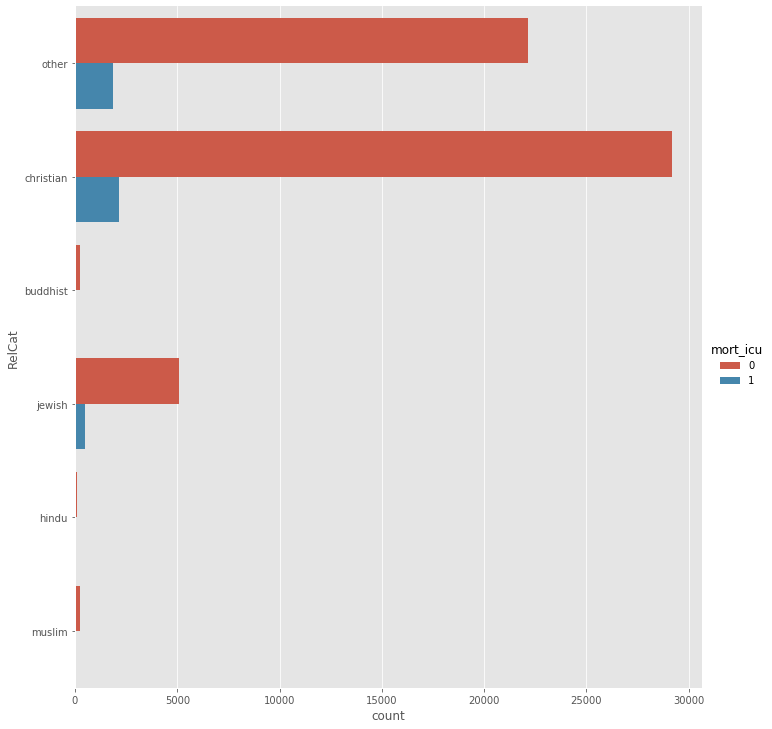

In [27]:
mimiciii.RelCat.unique()
data = dict()
for e in mimiciii.RelCat.unique():
  data[e] = [mimiciii[mimiciii.RelCat == e][['mort_icu']].values,
                mimiciii[mimiciii.RelCat == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_religion')
sbs.catplot(y='RelCat', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)